In [5]:
#Install the Kaggle library
! pip install kaggle
#Make a directory named “.kaggle”
#! mkdir ~/.kaggle
#Copy the “kaggle.json” api into this new directory
! cp kaggle.json ~/.kaggle/
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:03<00:00, 14.2MB/s]
100% 66.0M/66.0M [00:03<00:00, 22.9MB/s]


In [7]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [8]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [14]:
df = pd.read_csv("/content/creditcard.csv")

In [64]:
df.shape

(284807, 31)

In [66]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

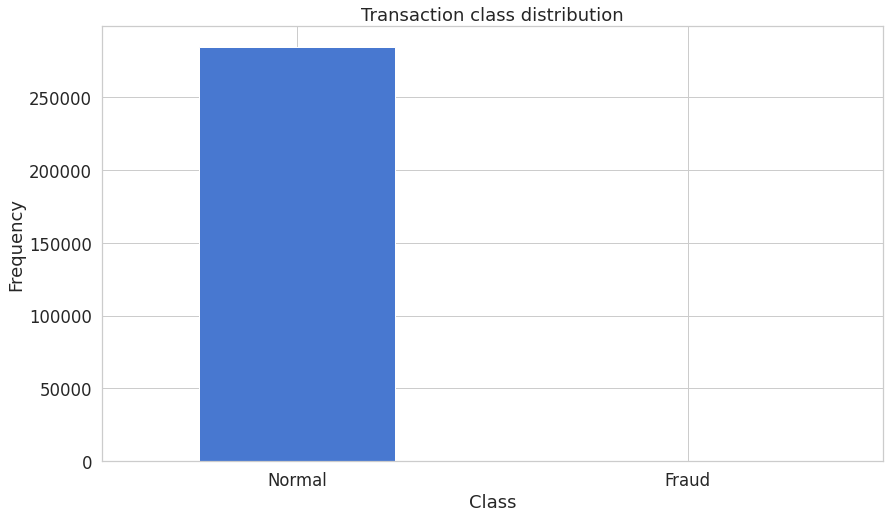

In [67]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [15]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [16]:
frauds.shape

(492, 31)

In [68]:
normal.shape

(284315, 31)

In [69]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [70]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

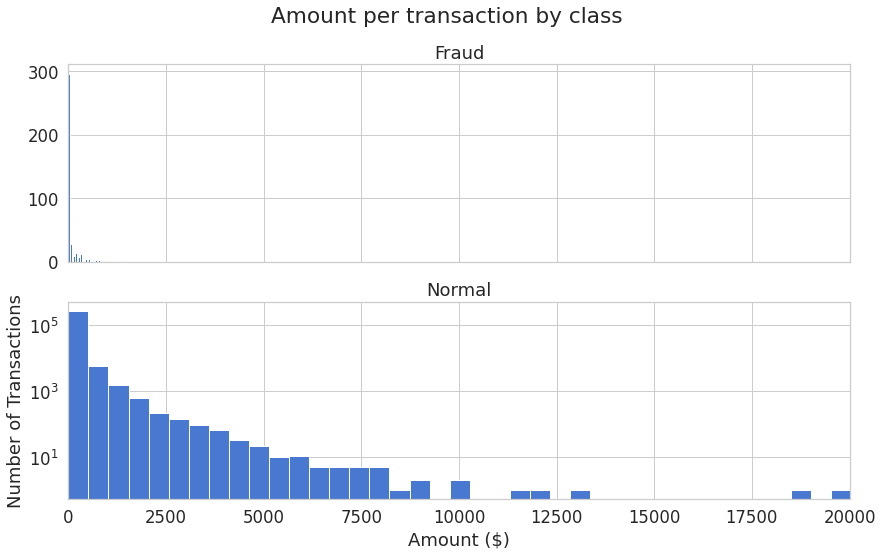

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

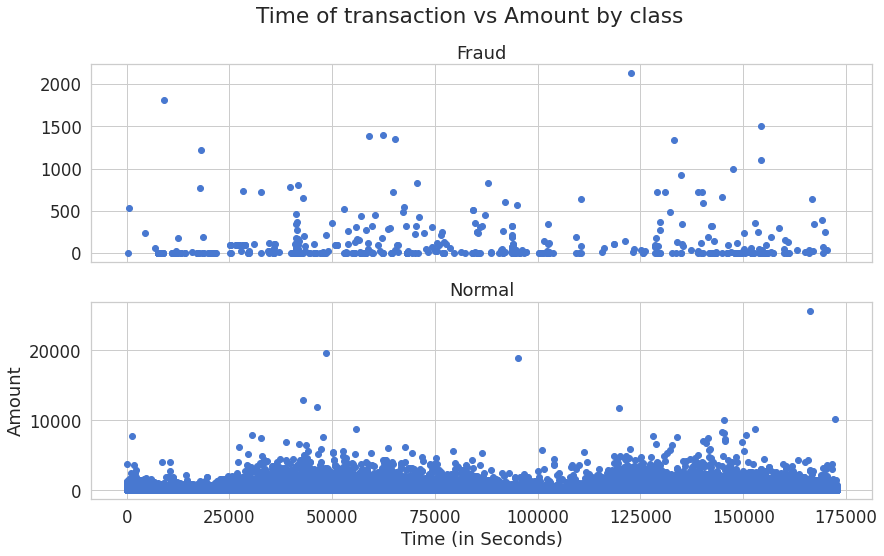

In [72]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [18]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [73]:
X_train.shape

(227451, 29)

In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [22]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 18s 2ms/step - loss: 3.4987e-04 - accuracy: 0.9476 - val_loss: 0.0017 - val_accuracy: 0.9982
Epoch 2/100
7108/7108 [==============================] - 21s 3ms/step - loss: 3.2844e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 3/100
7108/7108 [==============================] - 16s 2ms/step - loss: 3.1350e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 4/100
7108/7108 [==============================] - 28s 4ms/step - loss: 2.9957e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 5/100
7108/7108 [==============================] - 24s 3ms/step - loss: 2.9327e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 6/100
7108/7108 [==============================] - 29s 4ms/step - loss: 2.8902e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 7/100
7108/7108 [==============================] - 26s 4ms/step - loss: 2.8328e-06 - accuracy:

In [24]:
autoencoder = load_model('model.h5')

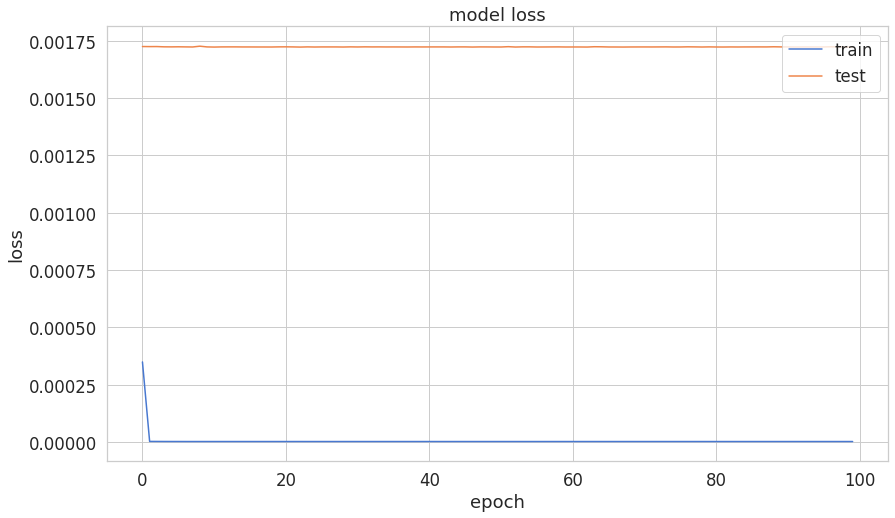

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.savefig('loss')

In [28]:
predictions = autoencoder.predict(X_test)

In [29]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [31]:
error_df.head()

,reconstruction_error,true_class
43428,82.560169,1
49906,1.018381,0
29474,0.466393,0
276481,0.546897,0
278846,0.362820,0


In [33]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support)

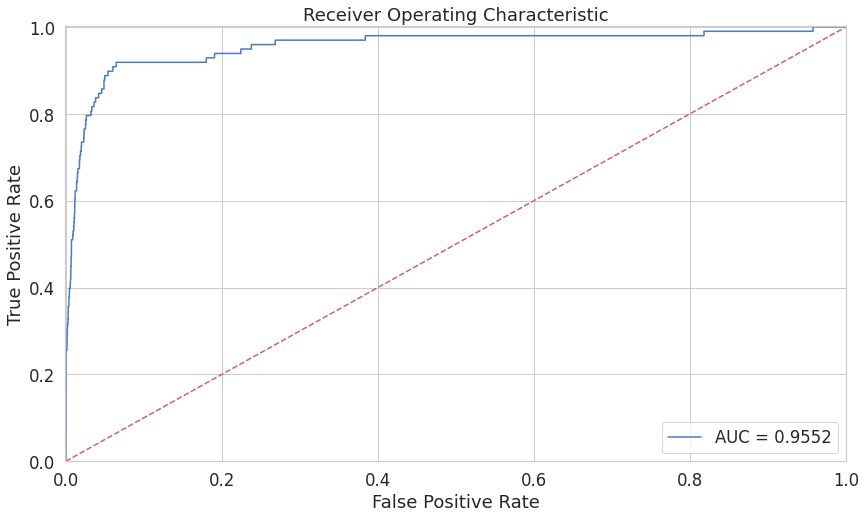

[2.61623184e+02 2.60623184e+02 1.99661091e+02 ... 2.11226944e-01
 2.11197875e-01 1.48072206e-01]


<Figure size 1008x576 with 0 Axes>

In [76]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
plt.savefig('ROC1')

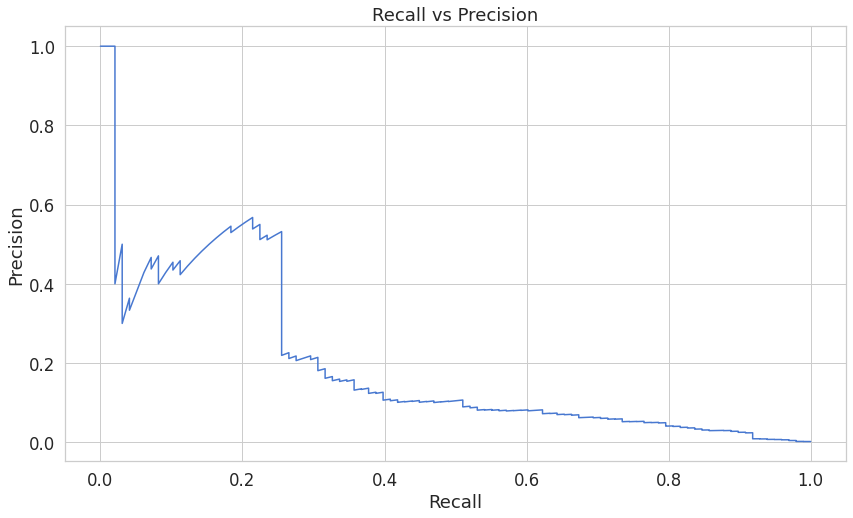

<Figure size 1008x576 with 0 Axes>

In [75]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
plt.savefig('Recall vs Precision')

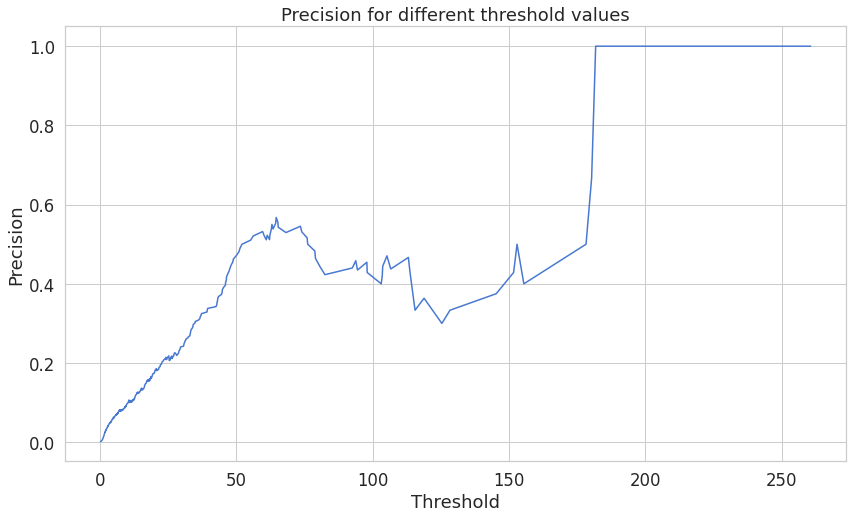

<Figure size 1008x576 with 0 Axes>

In [39]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()
plt.savefig('Precision for different threshold values')

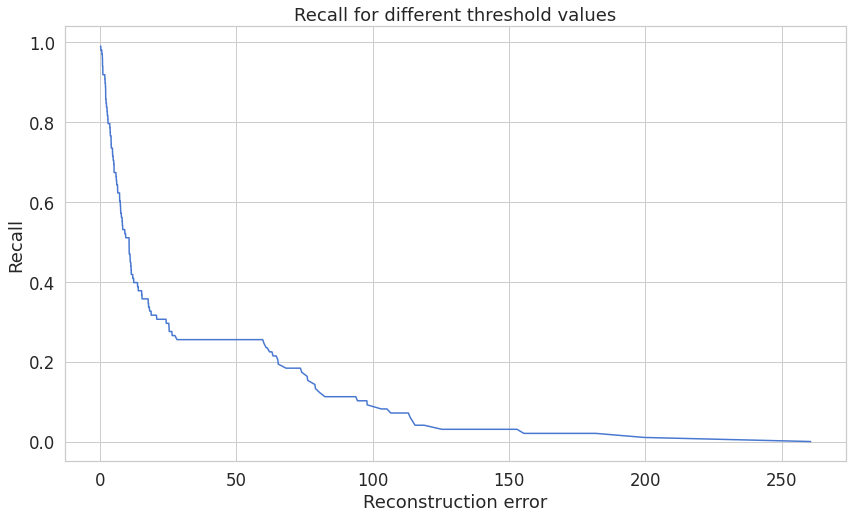

<Figure size 1008x576 with 0 Axes>

In [40]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()
plt.savefig('Recall for different threshold values')

In [54]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold=",threshold)
print("AUC=", roc_auc)

Threshold= 1.844247958864014
AUC= 0.9551929487326725


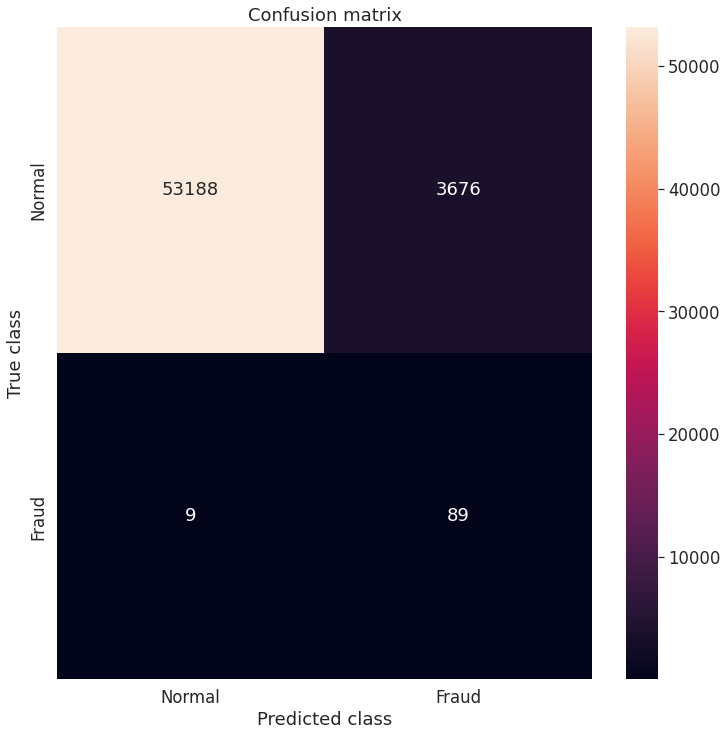

In [55]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [59]:
TP = conf_matrix[1,1] # true positive 
TN = conf_matrix[0,0] # true negatives
FP = conf_matrix[0,1] # false positives
FN = conf_matrix[1,0] # false negatives

In [62]:
# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Sensitivity:- 0.9081632653061225
Specificity:- 0.9353545301069218
